# 5G UE-VBS Selection ML Model
- <strong>Environment Setup:</strong> import libraries and load the dataset
- <strong>Imbalanced Data Analysis:</strong> understanding how the dataset balance is restored using random under sampling
- <strong>SMOTE:</strong> Creating synthetic data for the minority class using SMOTE(Synthetic Minority Over-sampling Technique), takes random samples from the minority class, finds its nearest k neighbors, and then selects a point between the randomly selected data point and its nearest k neighbors to generate synthetic data
- <strong>Inference:</strong> understand how the model produces results and choosing the best classifier

## Environmnet Setup

In [1]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Model Selection
from sklearn.model_selection import cross_val_score

# Imbalanced dataset helpers
from imblearn.over_sampling import SMOTE

In [2]:
# Loading the dataset
dataset_location = './Data/encoded_master_simulation_1000_2500.csv'
df = pd.read_csv(dataset_location, index_col=0)
df.head()

,distance_from_base_station,battery_discharge_rate,power,memory,cpu_power,qos,qoe,data_rate,eligibility
0,465.575800,45.312870,9.301212,6,65.953269,0.992467,0.147388,3.237754e+04,0
1,383.632002,107.164485,10.982724,12,48.639950,0.993799,0.136998,4.545044e+05,0
2,178.448694,42.099486,17.630753,6,88.386756,0.995114,0.125348,4.774090e+04,0
3,519.320506,117.518415,8.352311,8,93.333433,0.992822,0.143667,1.416554e+06,0
4,643.812013,67.063529,6.485839,4,30.084433,0.992436,0.148444,5.775633e+04,0


In [3]:
# Understanding the column data
print(df.info())
print(f"\nShape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 5249
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   distance_from_base_station  5250 non-null   float64
 1   battery_discharge_rate      5250 non-null   float64
 2   power                       5250 non-null   float64
 3   memory                      5250 non-null   int64  
 4   cpu_power                   5250 non-null   float64
 5   qos                         5250 non-null   float64
 6   qoe                         5250 non-null   float64
 7   data_rate                   5250 non-null   float64
 8   eligibility                 5250 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 410.2 KB
None

Shape: (5250, 9)


## Dataset Without Handling Imbalance

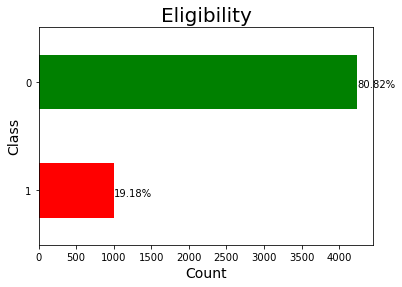

0    4243
1    1007
Name: eligibility, dtype: int64


In [4]:
# Plotting the percentage of observations that fall under each class
ax = df["eligibility"].value_counts().sort_values().plot(kind="barh", color=["r", "g"])
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Eligibility", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(df["eligibility"].value_counts())
fig = ax.get_figure()
fig.savefig("Fig/04-01-Class_Imbalance.png")
fig.savefig("Eps/04-01-Class_Imbalance.eps", format='eps')

In [5]:
features = df.loc[:, df.columns != "eligibility"]
labels = np.asarray(df["eligibility"])
# Number of samples/observations/rows is greater than 100,000
print(f"\nDataset shape: {df.shape}")
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.30, random_state=42)
print(f"features_train shape: {features_train.shape} | features_test shape: {features_test.shape}")
print(f"labels_train shape: {labels_train.shape} | labels_test shape: {labels_test.shape}")
# print(f"{features_train.shape[1]} Features: {features_train.columns.to_list()}")


Dataset shape: (5250, 9)
features_train shape: (3675, 8) | features_test shape: (1575, 8)
labels_train shape: (3675,) | labels_test shape: (1575,)


## Training Data Without Handling Imbalance

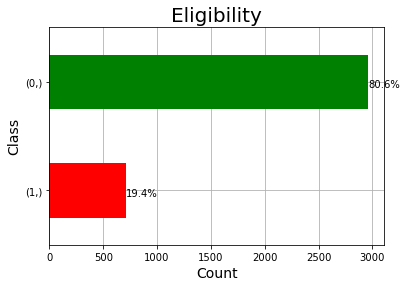

0    2962
1     713
dtype: int64


In [6]:
# Plotting the percentage of observations that fall under each class
ax = pd.DataFrame(labels_train).value_counts().sort_values().plot(kind="barh", color=["r", "g"])
ax.set_axisbelow(True)
ax.grid()
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Eligibility", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(labels_train).value_counts())
fig = ax.get_figure()
fig.savefig("Fig/04-02-Training_Class_Imbalance.png")
fig.savefig("Eps/04-02-Training_Class_Imbalance.eps", format='eps')

## SMOTE

In [7]:
smote = SMOTE(random_state=42)
features_train, labels_train = smote.fit_resample(features_train, labels_train)

In [8]:
# SMOTE takes too long for large datasets
features_train.to_csv("./Data/smote_features_train.csv")
pd.DataFrame(labels_train).to_csv("./Data/smote_labels_train.csv")
features_train = pd.read_csv("./Data/smote_features_train.csv", index_col=0)
labels_train = pd.read_csv("./Data/smote_labels_train.csv", index_col=0)
# labels_train.shape
labels_train = labels_train["0"].values

## Balancing the Training Data

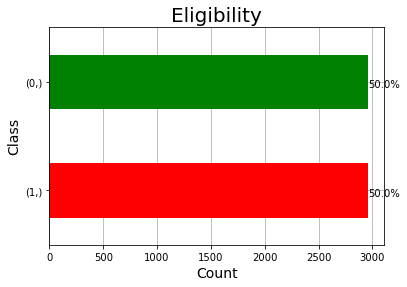

1    2962
0    2962
dtype: int64


In [9]:
# Plotting the percentage of observations that fall under each class
ax = pd.DataFrame(labels_train).value_counts().sort_values().plot(kind="barh", color=["r", "g"])
ax.set_axisbelow(True)
ax.grid()
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Eligibility", fontsize=20)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(labels_train).value_counts())
fig = ax.get_figure()
fig.savefig("Fig/04-03-Balanced.png")
fig.savefig("Eps/04-03-Balanced.eps", format='eps')

## Modeling Different Classifiers

### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1281
           1       0.85      0.91      0.88       294

    accuracy                           0.95      1575
   macro avg       0.91      0.94      0.92      1575
weighted avg       0.95      0.95      0.95      1575


Cross-Validation cv=5
0.95 0.96 0.98 0.96 0.98 

Mean: 0.96


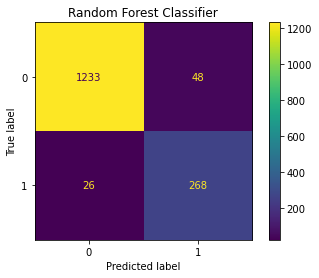

In [10]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(features_train, labels_train)
joblib.dump(model, "./SMOTE/RandomForestClassifier.joblib")
model = joblib.load("./SMOTE/RandomForestClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
# conf_mat_plot = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test)
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Random Forest Classifier")
plt.savefig("Fig/04-04-RFC_Confusion_Matrix_SMOTE.png")
plt.savefig("Eps/04-04-RFC_Confusion_Matrix_SMOTE.eps", format='eps')
print(conf_mat_plot)
print("\nCross-Validation cv=5")
scores = cross_val_score(model, features_train, labels_train, cv=5)
for score in scores:
    print("%.2f" %score, end=" ")
print("\n\nMean: %.2f" %scores.mean())
del model
del model_pred

### Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1281
           1       0.83      0.94      0.88       294

    accuracy                           0.95      1575
   macro avg       0.91      0.95      0.92      1575
weighted avg       0.96      0.95      0.95      1575


Cross-Validation cv=5
0.94 0.95 0.96 0.96 0.97 

Mean: 0.96


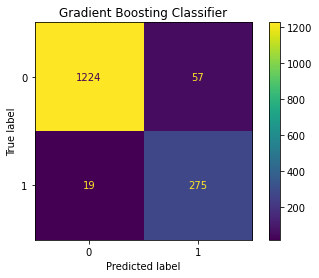

In [11]:
model = GradientBoostingClassifier(random_state=42)
model.fit(features_train, labels_train)
joblib.dump(model, "./SMOTE/GradientBoostingClassifier.joblib")
model = joblib.load("./SMOTE/GradientBoostingClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
# conf_mat_plot = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test)
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("Gradient Boosting Classifier")
plt.savefig("Fig/04-05-GBC_Confusion_Matrix_SMOTE.png")
plt.savefig("Eps/04-05-GBC_Confusion_Matrix_SMOTE.eps", format='eps')
print(conf_mat_plot)
print("\nCross-Validation cv=5")
scores = cross_val_score(model, features_train, labels_train, cv=5)
for score in scores:
    print("%.2f" %score, end=" ")
print("\n\nMean: %.2f" %scores.mean())
del model
del model_pred

### AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1281
           1       0.82      0.90      0.86       294

    accuracy                           0.94      1575
   macro avg       0.90      0.93      0.91      1575
weighted avg       0.95      0.94      0.95      1575


Cross-Validation cv=5
0.91 0.95 0.95 0.95 0.96 

Mean: 0.94


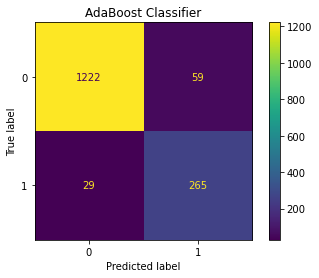

In [12]:
model = AdaBoostClassifier(random_state=42)
model.fit(features_train, labels_train)
joblib.dump(model, "./SMOTE/AdaBoostClassifier.joblib")
model = joblib.load("./SMOTE/AdaBoostClassifier.joblib")
model_pred = model.predict(features_test)
# print(confusion_matrix(labels_test, model_pred))
print(classification_report(labels_test, model_pred))
# conf_mat_plot = ConfusionMatrixDisplay.from_estimator(model, features_test, labels_test)
conf_mat_plot = plot_confusion_matrix(model, features_test, labels_test)
plt.title("AdaBoost Classifier")
plt.savefig("Fig/04-06-AdaBoost_Confusion_Matrix_SMOTE.png")
plt.savefig("Eps/04-06-AdaBoost_Confusion_Matrix_SMOTE.eps", format='eps')
print(conf_mat_plot)
print("\nCross-Validation cv=5")
scores = cross_val_score(model, features_train, labels_train, cv=5)
for score in scores:
    print("%.2f" %score, end=" ")
print("\n\nMean: %.2f" %scores.mean())
del model
del model_pred

## Performance Evaluation

In [13]:
# Setup
perf_df = pd.DataFrame(columns=["classifiers", "fpr", "tpr", "auc"])

classifiers = ["AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier"]
for clf in classifiers:
    # Load the trained classifiers
    model = joblib.load(f"./SMOTE/{clf}.joblib")
    model_pred = model.predict(features_test)
    fpr, tpr, _ = roc_curve(labels_test,  model_pred)
    auc = roc_auc_score(labels_test, model_pred)
    # Record the results
    perf_df = perf_df.append({"classifiers": clf,
                                        "fpr": fpr, 
                                        "tpr": tpr, 
                                        "auc": auc}, ignore_index=True)
    del model
    del model_pred

# Set name of the classifiers as index labels
perf_df.set_index("classifiers", inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


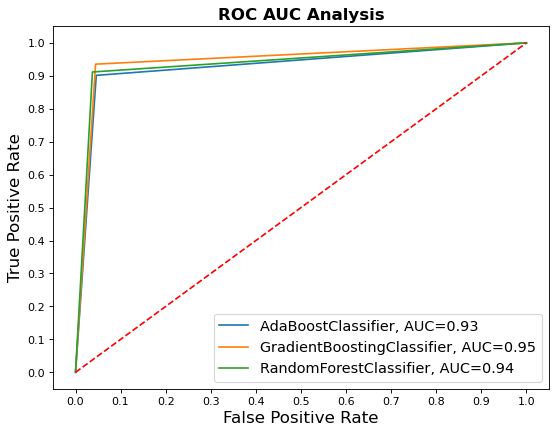

In [14]:
fig = plt.figure(figsize=(8,6), dpi=80)
for clf_name in perf_df.index:
    plt.plot(perf_df.loc[clf_name]["fpr"], 
             perf_df.loc[clf_name]["tpr"], 
             label="{}, AUC={:.2f}".format(clf_name, perf_df.loc[clf_name]["auc"]))
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title("ROC AUC Analysis", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.savefig("Fig/04-07-ROCAUC_After_SMOTE.png")
plt.savefig("Eps/04-07-ROCAUC_After_SMOTE.eps", format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


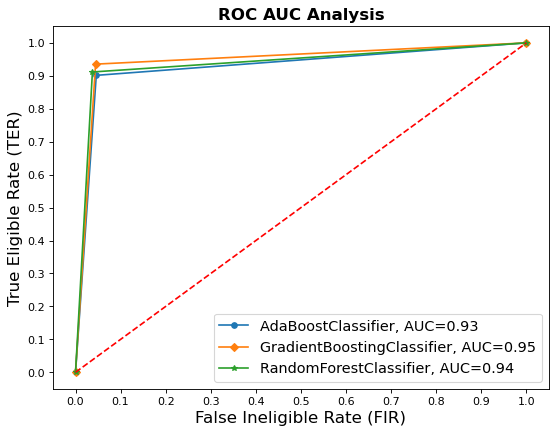

In [15]:
markers = 'oD*'
m = 0
fig = plt.figure(figsize=(8,6), dpi=80)
for clf_name in perf_df.index:
    plt.plot(perf_df.loc[clf_name]["fpr"], 
             perf_df.loc[clf_name]["tpr"], marker=markers[m], markersize='5',
             label="{}, AUC={:.2f}".format(clf_name, perf_df.loc[clf_name]["auc"]))
    m += 1
    
plt.plot([0,1], [0,1], color='red', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Ineligible Rate (FIR)", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Eligible Rate (TER)", fontsize=15)

plt.title("ROC AUC Analysis", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.savefig("Fig/04-08-ROCAUC_After_SMOTE.png")
plt.savefig("Eps/04-08-ROCAUC_After_SMOTE.eps", format='eps')
plt.show()